In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv(r"C:\Users\SANKET\OneDrive\Desktop\180 Projects\Parkinsson Disease\dataset.csv")
df.shape

(756, 755)

In [8]:
#Data have so many columns!!!
#lets check information about column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [10]:
df.isnull().sum().sum()

#There is no missing values

0

In [12]:
df.describe()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,...,tqwt_skewnessValue_dec_14,tqwt_skewnessValue_dec_15,tqwt_skewnessValue_dec_16,tqwt_skewnessValue_dec_17,tqwt_skewnessValue_dec_18,tqwt_skewnessValue_dec_19,tqwt_skewnessValue_dec_20,tqwt_skewnessValue_dec_21,tqwt_skewnessValue_dec_22,tqwt_skewnessValue_dec_23,tqwt_skewnessValue_dec_24,tqwt_skewnessValue_dec_25,tqwt_skewnessValue_dec_26,tqwt_skewnessValue_dec_27,tqwt_skewnessValue_dec_28,tqwt_skewnessValue_dec_29,tqwt_skewnessValue_dec_30,tqwt_skewnessValue_dec_31,tqwt_skewnessValue_dec_32,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,756.00000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,...,756.000000,756.000000,7.560000e+02,7.560000e+02,7.560000e+02,756.000000,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,7.560000e+02,756.000000,7.560000e+02,756.000000,756.000000,756.000000,7.560000e+02,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,125.500000,0.515873,0.746284,0.700414,0.489058,323.972222,322.678571,0.006360,0.000383,0.002324,1.673391e-05,0.000605,0.001159,0.001815,0.067473,0.60642,0.034375,0.041175,0.055366,0.103125,0.961508,0.051131,18.859632,70.828609,76.135371,73.997008,647.174519,1233.852088,2562.425251,3547.259244,213.363237,297.174077,536.821070,506.604856,0.904423,32.295832,4.454840,1.092503,0.215038,0.144832

Most of this data is from either primary sources or from raw form. So, we need lots of cleaning in data
* Data Cleaning : It includes dealing with null values, checking for incosistansis, outliers removal

In [19]:
#df = df.groupby('id').mean().reset_index()
#df.drop('id', axis=1, inplace=True)

#We dropped id column from data

There are so many columns derived from each other or with the help of each other. Therefore there are so high chances they are highly correlated. So, we create function that will deal with them Except Target column

In [21]:
columns = list(df.columns)

#col = for list(df.columns)
#col1 = for df.columns

for col in columns:
    if col == 'class':
        continue
        
    filtered_col = [col]
    for col1 in df.columns:
        if ((col1 == col) | (col == 'class')):
            continue
            
        val = df[col].corr(df[col1])
        
        if val > 0.7:
            columns.remove(col1)
            #If correlation between feature is more than 0.7 then it'll be remove from dataframe
            continue
            
            
        else:
            filtered_col.append(col1)
        
    df = df[filtered_col]   
#Now only columns will be available in df that are follow above iteration
    
df        

,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_1,tqwt_skewnessValue_dec_36,tqwt_skewnessValue_dec_32,tqwt_skewnessValue_dec_30,tqwt_skewnessValue_dec_29,tqwt_skewnessValue_dec_27,tqwt_skewnessValue_dec_26,tqwt_skewnessValue_dec_25,tqwt_skewnessValue_dec_24,tqwt_skewnessValue_dec_23,tqwt_skewnessValue_dec_22,tqwt_skewnessValue_dec_21,tqwt_skewnessValue_dec_20,tqwt_skewnessValue_dec_19,tqwt_skewnessValue_dec_18,tqwt_skewnessValue_dec_17,tqwt_skewnessValue_dec_16,tqwt_skewnessValue_dec_15,tqwt_skewnessValue_dec_14,tqwt_skewnessValue_dec_13,tqwt_skewnessValue_dec_12,tqwt_skewnessValue_dec_11,tqwt_skewnessValue_dec_9,tqwt_skewnessValue_dec_8,tqwt_skewnessValue_dec_7,tqwt_skewnessValue_dec_6,tqwt_skewnessValue_dec_3,tqwt_skewnessValue_dec_1,tqwt_maxValue_dec_30,tqwt_maxValue_dec_5,tqwt_maxValue_dec_1,tqwt_minValue_dec_35,tqwt_minValue_dec_32,tqwt_minValue_dec_30,tqwt_minValue_dec_28,tqwt_minValue_dec_26,tqwt_minValue_dec_24,tqwt_minValue_dec_22,tqwt_minValue_dec_20,tqwt_minValue_dec_18,tqwt_minValue_dec_14,tqwt_minValue_dec_11,tqwt_minValue_dec_8,tqwt_minValue_dec_4,...,mean_9th_delta,mean_8th_delta,mean_7th_delta,mean_6th_delta,mean_5th_delta,mean_4th_delta,mean_3rd_delta,mean_2nd_delta,mean_1st_delta,mean_delta_log_energy,mean_MFCC_12th_coef,mean_MFCC_11th_coef,mean_MFCC_10th_coef,mean_MFCC_9th_coef,mean_MFCC_8th_coef,mean_MFCC_7th_coef,mean_MFCC_6th_coef,mean_MFCC_5th_coef,mean_MFCC_4th_coef,mean_MFCC_3rd_coef,mean_MFCC_2nd_coef,mean_MFCC_1st_coef,mean_MFCC_0th_coef,mean_Log_energy,IMF_NSR_TKEO,IMF_NSR_SEO,IMF_SNR_TKEO,IMF_SNR_SEO,VFER_NSR_TKEO,VFER_SNR_SEO,VFER_SNR_TKEO,VFER_std,VFER_mean,GNE_NSR_SEO,GNE_SNR_SEO,GNE_SNR_TKEO,GNE_mean,GQ_std_cycle_closed,GQ_std_cycle_open,GQ_prc5_95,b4,b3,b2,b1,f4,f3,f2,f1,minIntensity,meanAutoCorrHarmonicity,locShimmer,locPctJitter,stdDevPeriodPulses,meanPeriodPulses,numPulses,RPDE,DFA,PPE,gender,class
0,2.6202,3.8686,1.5620,1.6058,2.0062,1.8314,1.9830,2.1993,2.9457,4.2077,2.4171,2.7224,7.7218,5.0622,6.9635,8.0024,66.5007,-2.730300,-0.285070,7.070000e-17,0.030756,0.000115,-1.660000e-17,-9.660000e-18,-4.290000e-19,-3.500000e-17,-1.390000e-17,-4.470000e-17,-4.330000e-18,0.000734,-9.370000e-18,2.210000e-17,1.510000e-17,0.007433,-0.003143,-5.850000e-17,1.010000e-15,-0.000362,-0.000829,-1.110000e-17,-0.005383,-0.004310,1.110000e-15,0.86453,0.017824,0.008518,0.014320,-0.006569,-0.012346,-0.017824,-0.360070,-0.458830,-0.45846,-0.44541,-0.32867,-0.61778,-0.108390,-0.026321,-0.026006,-0.006014,...,-0.004737,-0.000205,0.005187,0.001548,-0.003002,-0.000900,0.001357,-0.000192,-0.003364,-0.001013,-0.672740,-0.006825,0.547750,0.091821,0.61775,0.39725,-1.51440,-1.63340,0.55527,0.02292,2.48740,8.4781,11.4283,9.1817,5.8573,0.26850,5.77840,51.6843,1.2825,455.9654,209.6062,0.000260,0.000463,3.0152,1200445.612,0.083127,1.17300,2.8277,11.7245,0.77778,396.643631,255.214830,83.147440,101.092218,3655.054806,2447.162183,1031.849040,539.342735,69.997496,0.970805,0.05883,0.00218,0.000087,0.008064,240,0.57227,0.71826,0.85247,1,1
1,6.5245,23.5155,1.5589,1.5772,2.0470,1.5783,1.6227,1.9824,3.0999,4.3794,3.0323,6.2958,60.8974,12.5514,20.2332,116.5331,8643.9860,5.229400,0.504530,3.630000e-16,-0.205900,0.000098,-6.280000e-18,8.090000e-18,-5.590000e-18,1.520000e-17,-1.010000e-17,-7.020000e-20,-9.330000e-19,0.000330,8.750000e-18,-3.910000e-18,-7.090000e-18,-0.000092,0.006114,-2.350000e-17,-3.680000e-15,0.178080,-0.033633,3.350000e-17,-0.101740,-0.401950,-3.290000e-15,-32.31440,0.055053,0.039817,0.048874,-0.007438,-0.019211,-0.055053,-0.385700,-0.340590,-0.29252,-0.26291,-0.25345,-0.50757,-0.101340,-0.070039,-0.056267,-0.035671,...,-0.000354,0.0025

Now data left with 313 columns, but still they are very high, It will decrease the performance of our model.
So, we are going to decrease number upto 30 using chi-square method

In [26]:
X = df.drop('class', axis=1)
#Class is our Target and to make changes in features number we need to drop it.

X_norm = MinMaxScaler().fit_transform(X)
#MinMaxScaler is a class from sklearn.preprocessing which is used for normalization. 
#It scales all the data features in the range [0, 1] or else in the range [-1, 1] if there are negative values in the dataset..
#By doing so, all features will be transformed into the range [0,1] 
#meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively

selector = SelectKBest(chi2, k=30)
#chi2 is a statistical test applied to two categorical variables to determine 
#if there is a relationship between them. In the context of feature selection, 
#it is used to score the features and select the most important ones

#The code I provided creates an instance of the SelectKBest class with the chi2 score function and sets the value of k to 30. 
#The SelectKBest method selects the features according to the k highest score.

selector.fit(X_norm, df['class'])

filtered_col = selector.get_support()
#selector.get_support() returns a boolean array that indicates which features are selected by the SelectKBest method. 
#The selected features are marked as True, while the unselected features are marked as False.

filtered_data = X.loc[:, filtered_col]
filtered_data['class'] = df['class']
#Added class in data

df = filtered_data
df.shape

(756, 31)

So, we used
* MinMaxScaler for Normalization
* SelectKBest for Feature Selection
and converted into (756,31) shape

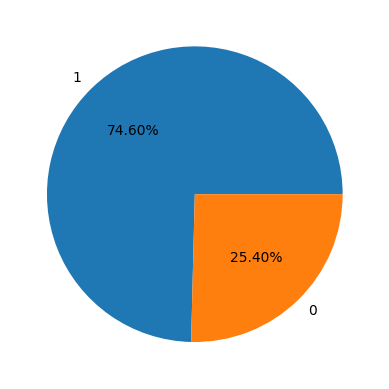

In [34]:
x = df['class'].value_counts()
plt.pie(x.values, labels= x.index, autopct='%1.2f%%')
plt.show()

#Our data is imbalanced

# Model Training

In [37]:
Target = df['class']
Features = df.drop('class', axis= 1)

X_train, X_valid, y_train, y_valid = train_test_split(Features, Target, train_size=0.8, test_size=0.2, random_state=8)

X_train.shape, X_valid.shape

((604, 30), (152, 30))

In [41]:
#Handling the data imbalance problem by using the over-sampling method on the minority class.
#we will balance it using repetative minorities rows

ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=0)
#RandomOverSampler is a method used for oversampling the minority class in an imbalanced dataset. 
#It generates new samples by randomly duplicating existing ones from the minority class until 
#the number of samples in the minority class is equal to the number of samples in the majority class.


X, Y = ros.fit_resample(X_train, y_train)
X.shape, Y.shape


((886, 30), (886,))

Now, we normalized all data some in cleaning process and some are now

In [51]:
from sklearn.metrics import roc_auc_score as ras

#The AUC score ranges between 0 and 1, with 1 representing a perfect classifier and 0.5 representing a random guess1. 
#A higher AUC score indicates better performance of the model.

from sklearn.linear_model import LogisticRegression

models = [LogisticRegression(), XGBClassifier()]

for i in range(len(models)):
    models[i].fit(X, Y)
    
    print(f'{models[i]} : ')
 
    train_preds = models[i].predict_proba(X)[:, 1]
    print('Training Accuracy : ', ras(Y, train_preds))
 
    val_preds = models[i].predict_proba(X_valid)[:, 1]
    print('Validation Accuracy : ', ras(y_valid, val_preds))
    print()

LogisticRegression() : 
Training Accuracy :  0.8104754673909167
Validation Accuracy :  0.8533724340175953

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...) : 
Training Accuracy :  1.0
Validation Accuracy :  0.9298853639029592



# Logistic Regression is Good model with Accuracy 85.33%

In [52]:
print(metrics.classification_report
      (y_valid, models[0].predict(X_valid)))

              precision    recall  f1-score   support

           0       0.47      0.87      0.61        31
           1       0.96      0.75      0.84       121

    accuracy                           0.78       152
   macro avg       0.72      0.81      0.73       152
weighted avg       0.86      0.78      0.80       152

